In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Multinomial Classification by Tensorflow 1.15 ver.

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Raw Data Loading
df = pd.read_csv('./data/mnist/train.csv')
display(df.head()) # (42000, 785)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


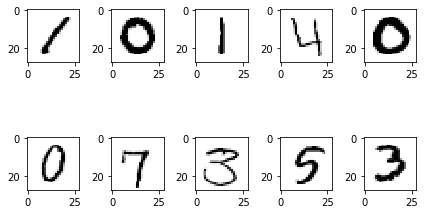

In [5]:
# 데이터 전처리 : 결측치나 이상치 없음. 단, 정규화는 필요함

# 이미지 확인
img_data = df.drop('label', axis=1, inplace=False).values

figure = plt.figure()
ax_arr = []

for n in range(10):
    ax_arr.append(figure.add_subplot(2,5,n+1))
    ax_arr[n].imshow(img_data[n].reshape(28,28), # 28 x 28 픽셀로 변환
                     cmap='Greys', # cmap은 흑백 이미지 처리
                     interpolation='nearest') # interpolation는 보간법(이미지 깨지지 않도록)
    
plt.tight_layout()
plt.show()

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Data Split
train_x_data, test_x_data, train_t_data, test_t_data = \
train_test_split(df.drop('label', axis=1, inplace=False), df['label'], test_size=0.3, random_state=1, stratify=df['label'])

# 정규화
scaler = MinMaxScaler()
scaler.fit(train_x_data)

norm_train_x_data = scaler.transform(train_x_data)
norm_test_x_data = scaler.transform(test_x_data)

# One-Hot Encoding 처리
sess = tf.Session()

onehot_train_t_data = sess.run(tf.one_hot(train_t_data, depth=10))
onehot_test_t_data = sess.run(tf.one_hot(test_t_data, depth=10))

# Placeholder
X = tf.placeholder(shape=[None,784], dtype=tf.float32) # 독립변수(feature)의 개수
T = tf.placeholder(shape=[None,10], dtype=tf.float32) # class의 logistic 개수

In [ ]:
# Weight, bias
W = tf.Variable(tf.random.normal([784,10])) # 독립변수 784개, 종속변수 10개. W는 7840개
b = tf.Variable(tf.random.normal([10])) # = logistic 개수

# Model, Hypothesis
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)

# Cross Entropy(loss func)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=T))

# Train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)

# Session 초기화
sess.run(tf.global_variables_initializer())

# 반복 학습
for step in range(5000):
    
    tmp, loss_val = sess.run([train, loss], feed_dict={X:norm_train_x_data, T:onehot_train_t_data})
    
    if step % 500 == 0:
        print('loss 값 : {}'.format(loss_val))





loss 값 : 15.461518287658691
loss 값 : 1.326549768447876


In [11]:
# 성능평가(Accuracy)
predict = tf.argmax(H,1) # axis=1(열 방향)으로 가장 큰 요소를 찾아라
correct = tf.equal(predict, tf.argmax(T,1)) # 예측과 정답이 맞는지에 대한 Boolean
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32)) # Boolean을 실수로 바뀜

# 학습 데이터로 성능평가를 하면 안됨! 이마저도 낮다면 학습이 안 된 것!
train_result = sess.run(accuracy, feed_dict={X:norm_train_x_data, T:onehot_train_t_data})
print('train 데이터의 정확도 : {}'.format(train_result)) # 0.8769387602806091

result = sess.run(accuracy, feed_dict={X:norm_test_x_data, T:onehot_test_t_data})
print('test 데이터의 정확도 : {}'.format(result)) # 0.8660317659378052

train 데이터의 정확도 : 0.7808163166046143
test 데이터의 정확도 : 0.7566666603088379


In [8]:
# Multinomial Classification by Tensorflow 1.15 ver. w/h Neural Network
# (Weight 초기화, Activation 변경, Dropout은 일단 제외)

# Weight, bias
W2 = tf.Variable(tf.random.normal([784,256]))
b2 = tf.Variable(tf.random.normal([256]))
layer2 = tf.sigmoid(tf.matmul(X,W2) + b2)

W3 = tf.Variable(tf.random.normal([256,128]))
b3 = tf.Variable(tf.random.normal([128]))
layer3 = tf.sigmoid(tf.matmul(layer2,W3) + b3)

W4 = tf.Variable(tf.random.normal([128,10]))
b4 = tf.Variable(tf.random.normal([10]))

# Model, Hypothesis
logit = tf.matmul(layer3,W4) + b4
H = tf.nn.softmax(logit)

# Cross Entropy(loss func)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=T))

# Train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)

# Session 초기화
sess.run(tf.global_variables_initializer())

# 반복 학습
for step in range(1000):
    
    tmp, loss_val = sess.run([train, loss], feed_dict={X:norm_train_x_data, T:onehot_train_t_data})
    
    if step % 100 == 0:
        print('loss 값 : {}'.format(loss_val))

loss 값 : 11.550267219543457
loss 값 : 2.205697536468506
loss 값 : 1.5338445901870728
loss 값 : 1.245466947555542
loss 값 : 1.0781234502792358
loss 값 : 0.9658823609352112
loss 값 : 0.8839429616928101
loss 값 : 0.8205621838569641
loss 값 : 0.7695373892784119
loss 값 : 0.7272635698318481


In [12]:
# NN 구현의 성능평가(Accuracy)
predict = tf.argmax(H,1) # axis=1(열 방향)으로 가장 큰 요소를 찾아라
correct = tf.equal(predict, tf.argmax(T,1)) # 예측과 정답이 맞는지에 대한 Boolean
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32)) # Boolean을 실수로 바뀜

# 학습 데이터로 성능평가를 하면 안됨! 이마저도 낮다면 학습이 안 된 것!
train_result = sess.run(accuracy, feed_dict={X:norm_train_x_data, T:onehot_train_t_data})
print('train 데이터의 정확도 : {}'.format(train_result)) # 0.7808163166046143

result = sess.run(accuracy, feed_dict={X:norm_test_x_data, T:onehot_test_t_data})
print('test 데이터의 정확도 : {}'.format(result)) # 0.7566666603088379

train 데이터의 정확도 : 0.7808163166046143
test 데이터의 정확도 : 0.7566666603088379


In [4]:
# Multinomial Classification by Tensorflow 1.15 ver. w/h Deep Learning
# (Weight 초기화, Activation 변경 : Sigmoid -> ReLU, Dropout)

import warnings
warnings.filterwarnings('ignore')

# Weight, bias
# W2 = tf.Variable(tf.random.normal([784,256]))
W2 = tf.get_variable('W2', shape=[784,256],
                     initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random.normal([256]))
_layer2 = tf.nn.relu(tf.matmul(X,W2) + b2)
layer2 = tf.nn.dropout(_layer2, rate=0.3) # 30% Drop-out

# W3 = tf.Variable(tf.random.normal([256,128]))
W3 = tf.get_variable('W3', shape=[256,128],
                     initializer=tf.contrib.layers.xavier_initializer())
# W3 = tf.get_variable('W3', shape=[256,128],
#                      initializer=tf.contrib.layers.variance_scaling_initializer())
b3 = tf.Variable(tf.random.normal([128]))
_layer3 = tf.nn.relu(tf.matmul(layer2,W3) + b3)
layer3 = tf.nn.dropout(_layer3, rate=0.3)

# W4 = tf.Variable(tf.random.normal([128,10]))
W4 = tf.get_variable('W4', shape=[128,10],
                     initializer=tf.contrib.layers.xavier_initializer())
# W4 = tf.get_variable('W4', shape=[128,10],
#                      initializer=tf.contrib.layers.variance_scaling__initializer())
b4 = tf.Variable(tf.random.normal([10]))

# Model, Hypothesis
logit = tf.matmul(layer3,W4) + b4
H = tf.nn.softmax(logit)

# Cross Entropy(loss func)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=T))

# Train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)

# Session 초기화
sess.run(tf.global_variables_initializer())

# 반복 학습
for step in range(5000):
    
    tmp, loss_val = sess.run([train, loss], feed_dict={X:norm_train_x_data, T:onehot_train_t_data})
    
    if step % 500 == 0:
        print('loss 값 : {}'.format(loss_val))


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



loss 값 : 3.470918655395508
loss 값 : 0.3408123850822449
loss 값 : 0.24845963716506958
loss 값 : 0.19750212132930756
loss 값 : 0.16650672256946564
loss 값 : 0.14401407539844513
loss 값 : 0.12636609375476837
loss 값 : 0.10995304584503174
loss 값 : 0.09653723984956741
loss 값 : 0.09178952872753143


In [5]:
# Deep Learning 구현의 성능평가(Accuracy)
predict = tf.argmax(H,1)
correct = tf.equal(predict, tf.argmax(T,1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

# 학습 데이터로 성능평가를 하면 안됨! 이마저도 낮다면 학습이 안 된 것!
train_result = sess.run(accuracy, feed_dict={X:norm_train_x_data, T:onehot_train_t_data})
print('train 데이터의 정확도 : {}'.format(train_result)) # 0.9743537306785583

result = sess.run(accuracy, feed_dict={X:norm_test_x_data, T:onehot_test_t_data})
print('test 데이터의 정확도 : {}'.format(result)) # 0.9568253755569458

train 데이터의 정확도 : 0.9743537306785583
test 데이터의 정확도 : 0.9568253755569458
